Задание: забрать данные из базы данных, выделить фичи для построения рекомендательной системы, построить две модели - классическую и ансамбль, результат положить обратно в базу данных.

Забираем данные

In [1]:
import pandas as pd

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [2]:
posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

count_feed_data.head()

,count
0,76892800


In [4]:
feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 15000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-29 12:09:28,82452,5195,view,0
1,2021-12-29 12:11:50,82452,3011,view,0
2,2021-12-29 12:12:49,82452,4844,view,0
3,2021-12-29 12:13:04,82452,5384,view,0
4,2021-12-29 12:13:47,82452,2750,view,0


### Работа с данными и фичи для контентной модели

In [5]:
feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
6,2021-12-29 12:18:09,82452,4739,like,0
24,2021-10-24 19:05:20,82453,6255,like,0
36,2021-10-24 19:22:34,82453,5834,like,0
52,2021-11-07 21:18:45,82453,3275,like,0
57,2021-11-07 21:25:07,82453,585,like,0
...,...,...,...,...,...
14999971,2021-12-08 21:10:40,113182,6361,like,0
14999974,2021-12-08 21:13:28,113182,3515,like,0
14999979,2021-12-08 21:17:55,113182,3534,like,0
14999981,2021-12-08 21:19:31,113182,6582,like,0


In [6]:
feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-29 12:09:28,82452,5195,view,0
1,2021-12-29 12:11:50,82452,3011,view,0
2,2021-12-29 12:12:49,82452,4844,view,0
3,2021-12-29 12:13:04,82452,5384,view,0
4,2021-12-29 12:13:47,82452,2750,view,0


По выбранной дате timestamp для всех пар (user_id, post_id) предсказать будет лайк или нет (в вероятностях)

In [7]:
user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [8]:
posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [9]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [10]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

/Users/katerina_dracheva/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# фичи на основе TfIdf
posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [13]:
[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [14]:
# кластеризация текста
from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.464377,0.479000,0.448320,0.438898,0.501505,0.570319,0.430367,0.118660,0.526449,0.371345,0.504141,0.538730,0.429764,0.439834,0.530655
1,0.327415,0.340711,0.285128,0.288583,0.374454,0.331167,0.256761,0.276199,0.414219,0.192169,0.419719,0.438026,0.155815,0.289547,0.422810
2,0.355840,0.362331,0.334454,0.313273,0.389696,0.527857,0.303111,0.159513,0.435749,0.177003,0.431661,0.475243,0.330164,0.315045,0.447418
3,0.292988,0.319849,0.273544,0.254403,0.351733,0.484807,0.256985,0.255790,0.389680,0.077495,0.404843,0.437560,0.257353,0.262325,0.411103
4,0.231464,0.258366,0.225979,0.155813,0.294418,0.449170,0.179049,0.315758,0.343678,0.087220,0.353024,0.390997,0.208949,0.175748,0.399543


In [15]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,7,0.464377,0.479000,0.448320,...,0.570319,0.430367,0.118660,0.526449,0.371345,0.504141,0.538730,0.429764,0.439834,0.530655
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,12,0.327415,0.340711,0.285128,...,0.331167,0.256761,0.276199,0.414219,0.192169,0.419719,0.438026,0.155815,0.289547,0.422810
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,7,0.355840,0.362331,0.334454,...,0.527857,0.303111,0.159513,0.435749,0.177003,0.431661,0.475243,0.330164,0.315045,0.447418
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.292988,0.319849,0.273544,...,0.484807,0.256985,0.255790,0.389680,0.077495,0.404843,0.437560,0.257353,0.262325,0.411103
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,9,0.231464,0.258366,0.225979,...,0.449170,0.179049,0.315758,0.343678,0.087220,0.353024,0.390997,0.208949,0.175748,0.399543


In [16]:
# датафрейм с новыми фичами

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-12-29 12:09:28,82452,5195,view,0,Deathtrap is not a whodunit. Its a who gonna d...,movie,5.955577,0.498884,0.000129,...,0.478233,0.220550,0.371466,0.368580,0.243778,0.356427,0.322959,0.286898,0.106266,0.440153
1,2021-12-29 12:11:50,82452,3011,view,0,If I am an indigenous woman living on a reserv...,covid,3.263779,0.392283,0.000071,...,0.477769,0.211319,0.366374,0.296350,0.224398,0.370662,0.401027,0.265973,0.153648,0.438915
2,2021-12-29 12:12:49,82452,4844,view,0,My favorite Jackie Chan movie will always be D...,movie,7.323935,0.472392,0.000159,...,0.482466,0.223153,0.365881,0.355052,0.221664,0.364701,0.379805,0.248428,0.107048,0.444453
3,2021-12-29 12:13:04,82452,5384,view,0,"This film was absolutely awful, I even feel un...",movie,7.184212,0.441773,0.000156,...,0.568846,0.379611,0.491377,0.484896,0.399942,0.477398,0.456120,0.411051,0.306649,0.518472
4,2021-12-29 12:13:47,82452,2750,view,0,Revealing our feelings is often the beginning ...,covid,2.278063,0.585141,0.000050,...,0.488132,0.232442,0.371231,0.271417,0.233646,0.375681,0.414028,0.286411,0.185696,0.446272


In [17]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-12-29 12:09:28,82452,5195,view,0,Deathtrap is not a whodunit. Its a who gonna d...,movie,5.955577,0.498884,0.000129,...,0.286898,0.106266,0.440153,1,32,Russia,Yekaterinburg,0,Android,ads
1,2021-12-29 12:11:50,82452,3011,view,0,If I am an indigenous woman living on a reserv...,covid,3.263779,0.392283,0.000071,...,0.265973,0.153648,0.438915,1,32,Russia,Yekaterinburg,0,Android,ads
2,2021-12-29 12:12:49,82452,4844,view,0,My favorite Jackie Chan movie will always be D...,movie,7.323935,0.472392,0.000159,...,0.248428,0.107048,0.444453,1,32,Russia,Yekaterinburg,0,Android,ads
3,2021-12-29 12:13:04,82452,5384,view,0,"This film was absolutely awful, I even feel un...",movie,7.184212,0.441773,0.000156,...,0.411051,0.306649,0.518472,1,32,Russia,Yekaterinburg,0,Android,ads
4,2021-12-29 12:13:47,82452,2750,view,0,Revealing our feelings is often the beginning ...,covid,2.278063,0.585141,0.000050,...,0.286411,0.185696,0.446272,1,32,Russia,Yekaterinburg,0,Android,ads


In [18]:
# выделение признаков из timestamp
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-12-29 12:09:28,82452,5195,view,0,Deathtrap is not a whodunit. Its a who gonna d...,movie,5.955577,0.498884,0.000129,...,0.440153,1,32,Russia,Yekaterinburg,0,Android,ads,12,12
1,2021-12-29 12:11:50,82452,3011,view,0,If I am an indigenous woman living on a reserv...,covid,3.263779,0.392283,0.000071,...,0.438915,1,32,Russia,Yekaterinburg,0,Android,ads,12,12
2,2021-12-29 12:12:49,82452,4844,view,0,My favorite Jackie Chan movie will always be D...,movie,7.323935,0.472392,0.000159,...,0.444453,1,32,Russia,Yekaterinburg,0,Android,ads,12,12
3,2021-12-29 12:13:04,82452,5384,view,0,"This film was absolutely awful, I even feel un...",movie,7.184212,0.441773,0.000156,...,0.518472,1,32,Russia,Yekaterinburg,0,Android,ads,12,12
4,2021-12-29 12:13:47,82452,2750,view,0,Revealing our feelings is often the beginning ...,covid,2.278063,0.585141,0.000050,...,0.446272,1,32,Russia,Yekaterinburg,0,Android,ads,12,12


In [19]:
df = df.drop([
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
82452   5195    2021-12-29 12:09:28       0          movie    5.955577   
        3011    2021-12-29 12:11:50       0          covid    3.263779   
        4844    2021-12-29 12:12:49       0          movie    7.323935   
        5384    2021-12-29 12:13:04       0          movie    7.184212   
        2750    2021-12-29 12:13:47       0          covid    2.278063   
        4739    2021-12-29 12:15:38       1          movie    6.500854   
        6791    2021-12-29 12:18:11       0          movie    9.224271   
        2014    2021-12-29 12:20:12       0           tech    8.223384   
        996     2021-12-29 12:23:09       0       politics    6.953019   
        1893    2021-12-29 12:25:55       0          sport    9.799996   
        1601    2021-12-29 12:27:59       0          sport    7.579009   
        910     2021-12-29 12:28:39       0  entertainment    7.763831   
        1969    2021-12-29 12:31:14       0           tech   10.824537   
        1690    2021-12-29 12:33:29       0          sport    8.603438   
        962     2021-12-29 12:35:45       0       politics    7.860405   
        1657    2021-12-29 12:35:56       0          sport    8.550321   
        1091    2021-12-29 12:38:34       0       politics    9.732873   
        1019    2021-12-29 12:39:56       0       politics   10.417506   
        1823    2021-12-29 12:40:33       0          sport    7.417525   
        3959    2021-12-29 12:43:14       0          covid    3.448849   
        1168    2021-12-29 12:45:33       0       politics    9.313357   
        6       2021-12-29 12:45:53       0       business    7.026784   
82453   6255    2021-10-24 19:04:47       1          movie   10.648209   
        1444    2021-10-24 19:05:22       0          sport    8.298711   
        3824    2021-10-24 19:07:30       0          covid    2.938519   
        720     2021-10-24 19:08:58       0  entertainment    8.279192   
        679     2021-10-24 19:10:05       0  entertainment    8.838406   
        7042    2021-10-24 19:12:15       0          movie    7.252779   
        770     2021-10-24 19:13:17       0  entertainment    6.808826   
        1904    2021-10-24 19:13:32       0          sport    8.531899   
        5392    2021-10-24 19:15:22       0          movie    4.099718   
        1522    2021-10-24 19:15:38       0          sport   10.575509   
        1899    2021-10-24 19:18:04       0          sport    8.050499   
        5834    2021-10-24 19:20:43       1          movie   10.537598   
        569     2021-10-24 19:22:36       0  entertainment   10.121465   
        4993    2021-10-24 19:25:34       0          movie    5.889458   
        1110    2021-10-24 19:27:41       0       politics    7.406551   
        5643    2021-10-24 19:30:33       0          movie    6.499566   
        4758    2021-10-24 19:33:26       0          movie    4.759724   
        5934    2021-10-24 19:33:54       0          movie    7.375016   
        6450    2021-10-24 19:34:48       0          movie    6.636276   
        5083    2021-10-24 19:37:14       0          movie    8.586251   
        6934    2021-10-24 19:38:47       0          movie    6.582803   
        7122    2021-10-24 19:40:53       0          movie    9.872472   
        4705    2021-10-24 19:41:32       0          movie    7.102843   
        4156    2021-10-24 19:43:31       0          covid    3.180478   
        5296    2021-10-24 19:44:06       0          movie    7.128518   
        3788    2021-10-24 19:44:46       0          covid    3.473820   
        3275    2021-11-07 21:17:23       1          covid    2.711388   
        1487    2021-11-07 21:18:47       0          sport   10.204919   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
82452   5195     0.498884  

In [20]:
# обучаю первую модель (дерево), разбиваю по времени (так как данные имеют временную структуру)

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [21]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((11176543,), (2223346,))

In [22]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                                
82453   6255             movie   10.648209  0.275248   0.000231           13   
        1444             sport    8.298711  0.405579   0.000180            6   
        3824             covid    2.938519  0.483899   0.000064            3   
        720      entertainment    8.279192  0.447419   0.000180            6   
        679      entertainment    8.838406  0.345734   0.000192           11   
...                        ...         ...       ...        ...          ...   
113182  3864             covid    2.423069  0.607709   0.000053            0   
        4990             movie    5.551446  0.449583   0.000121           13   
        4056             covid    3.254033  0.513774   0.000071            0   
        1788             sport    9.698899  0.618060   0.000211            6   
        1960              tech    7.252450  0.548780   0.000158            2   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
82453   6255                 0.293097              0.147397   
        1444                 0.277009              0.288190   
        3824                 0.125300              0.244905   
        720                  0.470551              0.475061   
        679                  0.510373              0.437735   
...                               ...                   ...   
113182  3864                 0.073017              0.341759   
        4990                 0.375208              0.309582   
        4056                 0.083791              0.302723   
        1788                 0.319311              0.273824   
        1960                 0.286272              0.307079   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
82453   6255                 0.297356              0.239159   
        1444                 0.277681              0.225213   
        3824                 0.276075              0.062043   
        720                  0.481468              0.432392   
        679                  0.508309              0.486218   
...                               ...                   ...   
113182  3864                 0.366601              0.172202   
        4990                 0.402234              0.331518   
        4056                 0.327135              0.126580   
        1788                 0.304387              0.281718   
        1960                 0.123853              0.234715   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
82453   6255                 0.139290  ...               0.458307       1   
        1444                 0.319862  ...               0.434247       1   
        3824                 0.277835  ...               0.427623       1   
        720                  0.498442  ...               0.577879       1   
        679                  0.511199  ...               0.601962       1   
...                               ...  ...                    ...     ...   
113182  3864                 0.370079  ...               0.485566       0   
        4990                 0.275766  ...               0.508079       0   
        4056                 0.332769  ...               0.457408       0   
        1788                 0.298391  ...               0.429136       0   
        1960                 0.338355  ...               0.367952       0   

                 age  country         city  exp_group       os   source  hour  \
user_id post_id                                                                 
82453   6255      24   Russia      Apatity          2      iOS      ads    19   
        1444      24   Russia      Apatity          2      iOS      ads    19   
        3824      

In [23]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

/Users/katerina_dracheva/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/katerina_dracheva/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/katerina_dracheva/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [24]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.8974576686699597
Качество на тесте: 0.539852145084513


In [25]:
# вторая модель (катбуст)
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3560291	total: 2.81s	remaining: 4m 37s
1:	learn: 0.3489809	total: 5.34s	remaining: 4m 21s
2:	learn: 0.3478488	total: 7.6s	remaining: 4m 5s
3:	learn: 0.3470168	total: 9.8s	remaining: 3m 55s
4:	learn: 0.3468491	total: 11.9s	remaining: 3m 45s
5:	learn: 0.3465029	total: 13.7s	remaining: 3m 34s
6:	learn: 0.3463559	total: 15.9s	remaining: 3m 31s
7:	learn: 0.3462788	total: 17.4s	remaining: 3m 20s
8:	learn: 0.3460231	total: 19.3s	remaining: 3m 14s
9:	learn: 0.3453429	total: 21.1s	remaining: 3m 10s
10:	learn: 0.3445758	total: 23.2s	remaining: 3m 7s
11:	learn: 0.3445448	total: 25.2s	remaining: 3m 4s
12:	learn: 0.3442875	total: 27.1s	remaining: 3m 1s
13:	learn: 0.3440762	total: 29s	remaining: 2m 58s
14:	learn: 0.3437595	total: 30.9s	remaining: 2m 55s
15:	learn: 0.3436759	total: 32.9s	remaining: 2m 52s
16:	learn: 0.3436618	total: 34.7s	remaining: 2m 49s
17:	learn: 0.3436391	total: 36.7s	remaining: 2m 47s
18:	learn: 0.3435942	total: 38.6s	remaining: 2m 44s
19:	learn: 0.3433573	total: 40

In [26]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6651557071573045
Качество на тесте: 0.6487097839278715


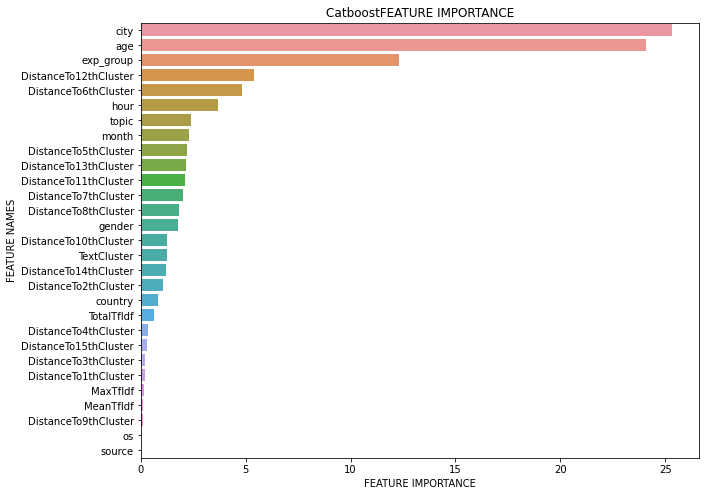

In [27]:
# смотрим важность признаков
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # перевожу данные в словарь 
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    # сортировка дф в порядке убывания важности
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    # строю график
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [28]:
catboost.save_model(
    'catboost_model',
    format="cbm"                  
)

Сохраняю в базу данных результаты

In [29]:
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml")

posts_info.to_sql(    
   "menshikova_features_lesson_22",                    
    con=engine,                                     
    if_exists='replace'            
   )                               
                                   

23

In [30]:
# проверяю, что всё добавилось 
test_ = pd.read_sql(
    """SELECT * FROM menshikova_features_lesson_22""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,7,0.464377,0.479000,...,0.570319,0.430367,0.118660,0.526449,0.371345,0.504141,0.538730,0.429764,0.439834,0.530655
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,12,0.327415,0.340711,...,0.331167,0.256761,0.276199,0.414219,0.192169,0.419719,0.438026,0.155815,0.289547,0.422810
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,7,0.355840,0.362331,...,0.527857,0.303111,0.159513,0.435749,0.177003,0.431661,0.475243,0.330164,0.315045,0.447418
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.292988,0.319849,...,0.484807,0.256985,0.255790,0.389680,0.077495,0.404843,0.437560,0.257353,0.262325,0.411103
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,9,0.231464,0.258366,...,0.449170,0.179049,0.315758,0.343678,0.087220,0.353024,0.390997,0.208949,0.175748,0.399543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,4,0.500325,0.412913,...,0.619040,0.462289,0.555386,0.563224,0.478345,0.554709,0.572735,0.484339,0.388064,0.594568
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146,4,0.373976,0.309706,...,0.542378,0.334161,0.455385,0.448582,0.365305,0.455044,0.486645,0.372309,0.245360,0.502054
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,1,0.281328,0.066960,...,0.503960,0.255198,0.401278,0.381283,0.279411,0.406425,0.391416,0.308591,0.166020,0.455136
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,1,0.324381,0.166486,...,0.497443,0.273819,0.402687,0.411501,0.298451,0.406868,0.355983,0.313972,0.188741,0.467776
